# Imports

In [20]:
import os
import torch
import random
import math
import h5py
import torchaudio
import logging
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
import seaborn as sns
from cycler import cycler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch.optim import lr_scheduler
from google.colab import drive, runtime
from tqdm import tqdm
from torch.utils.data import BatchSampler, TensorDataset, DataLoader, Dataset, Subset
from torchvision import models, transforms
from torchvision.transforms import v2
!pip install audiomentations
!pip install torch-audiomentations
!pip install torchinfo
!pip install pytorch-metric-learning
!pip install faiss-cpu
import faiss
import audiomentations as C
import torch_audiomentations as G
from pytorch_metric_learning import losses, miners, regularizers, samplers, distances, reducers, trainers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from torchinfo import summary

drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 81.5 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

Loading Data

In [2]:
with h5py.File('/content/drive/My Drive/Projects/NeuraBeat/Data/train_data.h5', 'r') as train_file:
    train_data = np.array(train_file['data'])
    train_labels = np.array(train_file['labels'])

with h5py.File('/content/drive/My Drive/Projects/NeuraBeat/Data/val_data.h5', 'r') as val_file:
    val_data = np.array(val_file['data'])
    val_labels = np.array(val_file['labels'])

with h5py.File('/content/drive/My Drive/Projects/NeuraBeat/Data/test_data.h5', 'r') as test_file:
    test_data = np.array(test_file['data'])
    test_labels = np.array(test_file['labels'])

Data Augmentation

In [3]:
class DataAugmentationCPU(nn.Module):
    def __init__(self):
        super(DataAugmentationCPU, self).__init__()
        self.transforms = C.Compose([
            C.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
            C.TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
            C.PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
        ])

    def forward(self, song, sample_rate):
        augmented_song = self.transforms(song, sample_rate=sample_rate)
        return augmented_song

Create Dataset

In [4]:
class AudioDataset(Dataset):
    def __init__(self, input_data, input_labels, sample_rate=16000, n_mels=128, mean=6.5304, std=11.8924, transform=None):
        self.input_data = input_data
        self.input_labels = input_labels
        self.sr = sample_rate
        self.n_mels = n_mels
        self.mean = mean
        self.std = std
        self.transform = transform
        self.mel_spec_transform = T.MelSpectrogram(sample_rate=self.sr, n_mels=self.n_mels, n_fft=2048, hop_length=512)
        self.log_mel_spec_transform = T.AmplitudeToDB()
        self.image_transforms = transform = v2.Compose([
                                                        v2.Resize((64, 47)),
                                                        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                                                        v2.Normalize((self.mean,), (self.std,))
                                                    ])

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        song = self.input_data[idx]
        genre = self.input_labels[idx]
        if self.transform:
            song = self.transform(song, self.sr)

        mel_spec = self.mel_spec_transform(torch.from_numpy(song))
        log_mel_spec = self.log_mel_spec_transform(mel_spec)
        mel_spec_tensor = log_mel_spec.unsqueeze(0)
        mel_spec_tensor = self.image_transforms(mel_spec_tensor)

        return mel_spec_tensor, genre

batch_size = 960

audio_train_dataset = AudioDataset(input_data=train_data, input_labels=train_labels, transform=None)
audio_val_dataset = AudioDataset(input_data=val_data, input_labels=val_labels, transform=None)
audio_test_dataset = AudioDataset(input_data=test_data, input_labels=test_labels, transform=None)

train_batch_sampler = samplers.MPerClassSampler(labels=audio_train_dataset.input_labels, m=120, batch_size=batch_size)
val_batch_sampler = samplers.MPerClassSampler(labels=audio_val_dataset.input_labels, m=120, batch_size=batch_size)
test_batch_sampler = samplers.MPerClassSampler(labels=audio_test_dataset.input_labels, m=120, batch_size=batch_size)

audio_train_loader = DataLoader(audio_train_dataset, batch_size=batch_size, sampler=train_batch_sampler, pin_memory=True)
audio_val_loader = DataLoader(audio_val_dataset, batch_size=batch_size, sampler=val_batch_sampler, pin_memory=True)
audio_test_loader = DataLoader(audio_test_dataset, batch_size=batch_size, sampler=test_batch_sampler, pin_memory=True)

Dataset Mean/Std

In [5]:
# From: https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
def dataset_mean_std(data_loader):
  nimages = 0
  mean = 0.
  std = 0.
  for batch, _ in data_loader:
      # Rearrange batch to be the shape of [B, C, W * H]
      batch = batch.view(batch.size(0), batch.size(1), -1)
      # Update total number of images
      nimages += batch.size(0)
      # Compute mean and std here
      mean += batch.float().mean(2).sum(0)
      std += batch.float().std(2).sum(0)

  # Final step
  mean /= nimages
  std /= nimages

  print("Training set mean", mean)
  print("Training set std", std)

  return mean, std

# Model

Print Layer (debugging)

In [6]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        # Do your print / debug stuff here
        print("X shape:", x.shape)
        return x


Positional Encoding

In [7]:
# From: https://github.com/wzlxjtu/PositionalEncoding2D
class PositionalEncoding2d(nn.Module):
    def __init__(self, d_model, height, width):
        super(PositionalEncoding2d, self).__init__()
        if d_model % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dimension (got dim={:d})".format(d_model))
        pe = torch.zeros(d_model, height, width)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                            -(math.log(10000.0) / d_model))
        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)
        pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe

Separable Convolution 2D Layer

In [8]:
# Inspired by: https://github.com/reshalfahsi/separableconv-torch
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

Residual Block

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int, num_layers: int):
        super().__init__()
        assert num_layers >= 2, "num_layers must be at least 2"
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        self.inconv = nn.Sequential(
            SeparableConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, bias=False),
            nn.SELU()
        )

        layers = []
        for _ in range(num_layers - 2):
            layers.append(SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, bias=False))
            layers.append(nn.SELU())
        self.convlayers = nn.Sequential(*layers)

        self.out_conv = SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, bias=False)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
        self.sact = nn.SELU()

    def forward(self, x):
        out = self.inconv(x)
        out = self.convlayers(out)
        out = self.out_conv(out)

        shortcut = self.shortcut(x)
        out = out + shortcut
        out = self.sact(out)

        return out

Embedding Model

In [10]:
class EmbeddingModel(nn.Module):
    def __init__(self):
      super(EmbeddingModel, self).__init__()
      self.input_layer = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, bias=False),
          nn.SELU(),
      )

      self.conv_layers = nn.Sequential(
          ResidualBlock(in_channels=8, out_channels=8, kernel_size=3, stride=2, num_layers=2),
          ResidualBlock(in_channels=8, out_channels=16, kernel_size=3, stride=2, num_layers=2),
          ResidualBlock(in_channels=16, out_channels=32, kernel_size=3, stride=2, num_layers=2),
          ResidualBlock(in_channels=32, out_channels=64, kernel_size=3, stride=2, num_layers=2),
      )

      self.dense_layers = nn.Sequential(
          nn.Linear(in_features=64, out_features=256, bias=False),
          nn.SELU(),
          nn.Linear(in_features=256, out_features=128, bias=False),
          nn.SELU(),
          nn.Linear(in_features=128, out_features=64)
      )

    def forward(self, x):
      x = self.input_layer(x)
      x = self.conv_layers(x)
      x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)
      x = self.dense_layers(x)
      return x

    def get_embedding(self, x):
      return self.forward(x)

# Utils

Early Stopping

In [11]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def reset_loss(self):
        self.min_validation_loss = float('inf')

Autoclip

In [12]:
# From: https://github.com/pseeth/autoclip/blob/master/autoclip.py
class AutoClip:
    def __init__(self, percentile):
        self.grad_history = []
        self.percentile = percentile

    def compute_grad_norm(self, model):
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)

        return total_norm

    def __call__(self, model):
        grad_norm = self.compute_grad_norm(model)
        self.grad_history.append(grad_norm)
        clip_value = np.percentile(self.grad_history, self.percentile)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

Model Checkpoint

In [13]:
def save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses, train_mined_triplets, val_mined_triplets):
  checkpoint = {
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          'train_losses': train_losses,
          'val_losses': val_losses,
          'train_mined_triplets': train_mined_triplets,
          'val_mined_triplets': val_mined_triplets
      }
  torch.save(checkpoint, f'/content/drive/My Drive/Projects/NeuraBeat/Checkpoints/model_checkpoint_{epoch}.pt')
  torch.save(model.state_dict(), f'/content/drive/My Drive/Projects/NeuraBeat/Models/embedding_model_{epoch}.pt')

def load_checkpoint(filepath, model, optimizer, scheduler):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_mined_triplets = checkpoint['train_mined_triplets']
    val_mined_triplets = checkpoint['val_mined_triplets']
    return model, optimizer, scheduler, start_epoch, train_losses, val_losses, train_mined_triplets, val_mined_triplets

# Training

Train Loop

In [14]:
def train_loop(train_loader, model, miner, criterion, optimizer, device, epoch):
    size = len(train_loader.dataset)
    model.train()
    avg_train_loss = 0.0
    avg_mined_triplets = 0.0
    num_batches = len(train_loader)

    for batch, (inputs, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        triplets = miner(outputs, targets)

        loss = criterion(outputs, targets, triplets)
        avg_train_loss += loss.item()
        avg_mined_triplets += miner.num_triplets
        loss.backward()

        autoclipper(model)
        optimizer.step()

        if (batch + 1) % 10 == 0:
            current_loss = avg_train_loss / (batch + 1)
            current_mined_triplets = avg_mined_triplets / (batch + 1)
            print(f"Training loss: {current_loss:>7f} - Train mined triplets: {current_mined_triplets:>7f}")

    avg_train_loss = avg_train_loss / num_batches
    avg_mined_triplets = avg_mined_triplets / num_batches
    return avg_train_loss, avg_mined_triplets

Val Loop

In [15]:
def val_loop(val_loader, model, miner, criterion, device, epoch):
    model.eval()
    avg_val_loss = 0.0
    avg_mined_triplets = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            triplets = miner(outputs, targets)

            loss = criterion(outputs, targets, triplets)
            avg_val_loss += loss.item()
            avg_mined_triplets += miner.num_triplets


    avg_val_loss = avg_val_loss / num_batches
    avg_mined_triplets = avg_mined_triplets / num_batches
    return avg_val_loss, avg_mined_triplets

Training

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
embedding_model = EmbeddingModel().to(device)
start_epoch = 0
num_epochs = 30
learning_rate = 0.001
margin = 0.2
loss_fn = losses.TripletMarginLoss(margin=margin, distance=distances.LpDistance(),
                                     embedding_regularizer=regularizers.LpRegularizer())
miner = miners.TripletMarginMiner(margin=margin, type_of_triplets="semihard")
optimizer = optim.AdamW(embedding_model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=num_epochs)
autoclipper = AutoClip(percentile=10)

train_losses = []
val_losses = []
train_mined_triplets = []
val_mined_triplets = []

print(summary(embedding_model, input_size=(batch_size, 1, 64, 47)))

# checkpoint_path = '/content/drive/My Drive/Projects/NeuraBeat/Checkpoints/model_checkpoint_95.pt'
# if os.path.isfile(checkpoint_path):
#     embedding_model, optimizer, scheduler, start_epoch, train_losses, val_losses = load_checkpoint(checkpoint_path, embedding_model, optimizer, scheduler)
#     print(f"Loaded checkpoint from epoch {start_epoch}")

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    avg_train_loss, avg_train_mined_triplets = train_loop(audio_train_loader, embedding_model, miner, loss_fn, optimizer, device, epoch+1)
    avg_val_loss, avg_val_mined_triplets = val_loop(audio_val_loader, embedding_model, miner, loss_fn, device, epoch+1)
    print(f"Train loss: {avg_train_loss:>8f} - Val loss: {avg_val_loss:>8f} \n")
    print(f"Train mined triplets: {avg_train_mined_triplets:>8f} - Val mined triplets: {avg_val_mined_triplets:>8f} \n")
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_mined_triplets.append(avg_train_mined_triplets)
    val_mined_triplets.append(avg_val_mined_triplets)
    print("Last learning rate:", scheduler.get_last_lr())
    scheduler.step()
    save_checkpoint(embedding_model, optimizer, scheduler, epoch+1, train_losses, val_losses, train_mined_triplets, val_mined_triplets)

Layer (type:depth-idx)                        Output Shape              Param #
EmbeddingModel                                [960, 64]                 --
├─Sequential: 1-1                             [960, 8, 60, 43]          --
│    └─Conv2d: 2-1                            [960, 8, 60, 43]          200
│    └─SELU: 2-2                              [960, 8, 60, 43]          --
├─Sequential: 1-2                             [960, 64, 4, 3]           --
│    └─ResidualBlock: 2-3                     [960, 8, 30, 22]          --
│    │    └─Sequential: 3-1                   [960, 8, 60, 43]          136
│    │    └─Sequential: 3-2                   [960, 8, 60, 43]          --
│    │    └─SeparableConv2d: 3-3              [960, 8, 30, 22]          136
│    │    └─Conv2d: 3-4                       [960, 8, 30, 22]          64
│    │    └─SELU: 3-5                         [960, 8, 30, 22]          --
│    └─ResidualBlock: 2-4                     [960, 16, 15, 11]         --
│    │    └─Seque

 10%|▉         | 10/104 [00:16<02:28,  1.58s/it]

Training loss: 0.394211 - Train mined triplets: 16143567.000000


 19%|█▉        | 20/104 [00:32<02:16,  1.63s/it]

Training loss: 0.306031 - Train mined triplets: 15314206.250000


 29%|██▉       | 30/104 [00:48<01:57,  1.59s/it]

Training loss: 0.268455 - Train mined triplets: 14772548.200000


 38%|███▊      | 40/104 [01:03<01:40,  1.56s/it]

Training loss: 0.246378 - Train mined triplets: 14324401.250000


 48%|████▊     | 50/104 [01:19<01:22,  1.53s/it]

Training loss: 0.232144 - Train mined triplets: 14031923.160000


 58%|█████▊    | 60/104 [01:35<01:08,  1.57s/it]

Training loss: 0.221623 - Train mined triplets: 13798694.616667


 67%|██████▋   | 70/104 [01:51<00:54,  1.62s/it]

Training loss: 0.212937 - Train mined triplets: 13672870.714286


 77%|███████▋  | 80/104 [02:06<00:37,  1.58s/it]

Training loss: 0.206135 - Train mined triplets: 13541662.800000


 87%|████████▋ | 90/104 [02:22<00:21,  1.54s/it]

Training loss: 0.200825 - Train mined triplets: 13467137.400000


 96%|█████████▌| 100/104 [02:38<00:06,  1.55s/it]

Training loss: 0.196510 - Train mined triplets: 13370892.390000


100%|██████████| 104/104 [02:45<00:00,  1.59s/it]


Train loss: 0.195023 - Val loss: 0.159813 

Train mined triplets: 13334000.894231 - Val mined triplets: 12046744.634615 

Last learning rate: [0.001]
Epoch 2
-------------------------------


 10%|▉         | 10/104 [00:15<02:29,  1.59s/it]

Training loss: 0.153336 - Train mined triplets: 12497936.100000


 19%|█▉        | 20/104 [00:31<02:08,  1.53s/it]

Training loss: 0.152606 - Train mined triplets: 12356131.950000


 29%|██▉       | 30/104 [00:47<01:52,  1.53s/it]

Training loss: 0.151601 - Train mined triplets: 12399569.533333


 38%|███▊      | 40/104 [01:02<01:43,  1.62s/it]

Training loss: 0.152400 - Train mined triplets: 12369118.325000


 48%|████▊     | 50/104 [01:18<01:26,  1.60s/it]

Training loss: 0.152340 - Train mined triplets: 12349180.040000


 58%|█████▊    | 60/104 [01:34<01:07,  1.54s/it]

Training loss: 0.152032 - Train mined triplets: 12308079.416667


 67%|██████▋   | 70/104 [01:49<00:52,  1.53s/it]

Training loss: 0.151514 - Train mined triplets: 12255263.871429


 77%|███████▋  | 80/104 [02:05<00:37,  1.55s/it]

Training loss: 0.150974 - Train mined triplets: 12219086.625000


 87%|████████▋ | 90/104 [02:21<00:22,  1.60s/it]

Training loss: 0.150684 - Train mined triplets: 12227651.622222


 96%|█████████▌| 100/104 [02:36<00:06,  1.58s/it]

Training loss: 0.150525 - Train mined triplets: 12196025.590000


100%|██████████| 104/104 [02:42<00:00,  1.57s/it]


Train loss: 0.150427 - Val loss: 0.144475 

Train mined triplets: 12165389.221154 - Val mined triplets: 11758704.000000 

Last learning rate: [0.0009972609476841367]
Epoch 3
-------------------------------


 10%|▉         | 10/104 [00:15<02:23,  1.53s/it]

Training loss: 0.145960 - Train mined triplets: 11707582.300000


 19%|█▉        | 20/104 [00:30<02:07,  1.52s/it]

Training loss: 0.145838 - Train mined triplets: 12003904.200000


 29%|██▉       | 30/104 [00:46<01:56,  1.58s/it]

Training loss: 0.146881 - Train mined triplets: 11999352.800000


 38%|███▊      | 40/104 [01:02<01:43,  1.61s/it]

Training loss: 0.146136 - Train mined triplets: 12100121.050000


 48%|████▊     | 50/104 [01:17<01:24,  1.56s/it]

Training loss: 0.145881 - Train mined triplets: 12095927.060000


 58%|█████▊    | 60/104 [01:33<01:08,  1.56s/it]

Training loss: 0.145122 - Train mined triplets: 12120181.500000


 67%|██████▋   | 70/104 [01:49<00:52,  1.55s/it]

Training loss: 0.144613 - Train mined triplets: 12188301.657143


 77%|███████▋  | 80/104 [02:05<00:38,  1.61s/it]

Training loss: 0.143913 - Train mined triplets: 12241988.175000


 87%|████████▋ | 90/104 [02:20<00:21,  1.56s/it]

Training loss: 0.143353 - Train mined triplets: 12252723.966667


 96%|█████████▌| 100/104 [02:36<00:06,  1.56s/it]

Training loss: 0.142788 - Train mined triplets: 12279718.210000


100%|██████████| 104/104 [02:42<00:00,  1.56s/it]


Train loss: 0.142524 - Val loss: 0.136635 

Train mined triplets: 12289404.067308 - Val mined triplets: 12442437.307692 

Last learning rate: [0.0009890738003669028]
Epoch 4
-------------------------------


 10%|▉         | 10/104 [00:15<02:25,  1.55s/it]

Training loss: 0.138299 - Train mined triplets: 12546102.400000


 19%|█▉        | 20/104 [00:31<02:16,  1.62s/it]

Training loss: 0.136225 - Train mined triplets: 12613775.400000


 29%|██▉       | 30/104 [00:47<01:55,  1.56s/it]

Training loss: 0.135860 - Train mined triplets: 12598444.600000


 38%|███▊      | 40/104 [01:03<01:39,  1.56s/it]

Training loss: 0.136359 - Train mined triplets: 12615050.400000


 48%|████▊     | 50/104 [01:18<01:22,  1.54s/it]

Training loss: 0.135865 - Train mined triplets: 12620925.760000


 58%|█████▊    | 60/104 [01:34<01:09,  1.58s/it]

Training loss: 0.135707 - Train mined triplets: 12621240.950000


 67%|██████▋   | 70/104 [01:50<00:53,  1.56s/it]

Training loss: 0.135377 - Train mined triplets: 12630680.528571


 77%|███████▋  | 80/104 [02:05<00:36,  1.54s/it]

Training loss: 0.134975 - Train mined triplets: 12611097.550000


 87%|████████▋ | 90/104 [02:21<00:21,  1.53s/it]

Training loss: 0.134497 - Train mined triplets: 12574098.844444


 96%|█████████▌| 100/104 [02:36<00:06,  1.52s/it]

Training loss: 0.134165 - Train mined triplets: 12567096.130000


100%|██████████| 104/104 [02:43<00:00,  1.57s/it]


Train loss: 0.134090 - Val loss: 0.130551 

Train mined triplets: 12543762.740385 - Val mined triplets: 12553524.115385 

Last learning rate: [0.0009755282581475768]
Epoch 5
-------------------------------


 10%|▉         | 10/104 [00:15<02:25,  1.54s/it]

Training loss: 0.129584 - Train mined triplets: 12359879.500000


 19%|█▉        | 20/104 [00:31<02:08,  1.53s/it]

Training loss: 0.129176 - Train mined triplets: 12454718.450000


 29%|██▉       | 30/104 [00:46<01:56,  1.57s/it]

Training loss: 0.128961 - Train mined triplets: 12448185.266667


 38%|███▊      | 40/104 [01:02<01:39,  1.55s/it]

Training loss: 0.128510 - Train mined triplets: 12419053.650000


 48%|████▊     | 50/104 [01:17<01:23,  1.55s/it]

Training loss: 0.128519 - Train mined triplets: 12344341.440000


 58%|█████▊    | 60/104 [01:33<01:08,  1.55s/it]

Training loss: 0.128288 - Train mined triplets: 12300813.483333


 67%|██████▋   | 70/104 [01:48<00:51,  1.52s/it]

Training loss: 0.128196 - Train mined triplets: 12282963.157143


 77%|███████▋  | 80/104 [02:04<00:36,  1.51s/it]

Training loss: 0.128021 - Train mined triplets: 12299201.150000


 87%|████████▋ | 90/104 [02:19<00:22,  1.58s/it]

Training loss: 0.128186 - Train mined triplets: 12308036.711111


 96%|█████████▌| 100/104 [02:35<00:06,  1.59s/it]

Training loss: 0.128181 - Train mined triplets: 12291183.970000


100%|██████████| 104/104 [02:41<00:00,  1.55s/it]


Train loss: 0.128166 - Val loss: 0.127175 

Train mined triplets: 12284209.586538 - Val mined triplets: 12269782.057692 

Last learning rate: [0.0009567727288213003]
Epoch 6
-------------------------------


 10%|▉         | 10/104 [00:15<02:22,  1.52s/it]

Training loss: 0.126817 - Train mined triplets: 11987246.500000


 19%|█▉        | 20/104 [00:31<02:19,  1.66s/it]

Training loss: 0.125983 - Train mined triplets: 12001164.100000


 29%|██▉       | 30/104 [00:47<01:57,  1.59s/it]

Training loss: 0.125357 - Train mined triplets: 12084782.100000


 38%|███▊      | 40/104 [01:02<01:39,  1.56s/it]

Training loss: 0.125029 - Train mined triplets: 12125984.300000


 48%|████▊     | 50/104 [01:18<01:23,  1.55s/it]

Training loss: 0.124679 - Train mined triplets: 12139747.580000


 58%|█████▊    | 60/104 [01:34<01:07,  1.54s/it]

Training loss: 0.124161 - Train mined triplets: 12143357.983333


 67%|██████▋   | 70/104 [01:49<00:53,  1.58s/it]

Training loss: 0.123910 - Train mined triplets: 12142041.042857


 77%|███████▋  | 80/104 [02:05<00:37,  1.56s/it]

Training loss: 0.123620 - Train mined triplets: 12197192.950000


 87%|████████▋ | 90/104 [02:21<00:21,  1.53s/it]

Training loss: 0.123402 - Train mined triplets: 12213052.400000


 96%|█████████▌| 100/104 [02:36<00:06,  1.56s/it]

Training loss: 0.123344 - Train mined triplets: 12207274.410000


100%|██████████| 104/104 [02:42<00:00,  1.57s/it]


Train loss: 0.123163 - Val loss: 0.119695 

Train mined triplets: 12211706.413462 - Val mined triplets: 12443519.903846 

Last learning rate: [0.0009330127018922195]
Epoch 7
-------------------------------


 10%|▉         | 10/104 [00:15<02:24,  1.54s/it]

Training loss: 0.121738 - Train mined triplets: 12325587.400000


 19%|█▉        | 20/104 [00:31<02:09,  1.54s/it]

Training loss: 0.122141 - Train mined triplets: 12290959.650000


 29%|██▉       | 30/104 [00:46<01:54,  1.55s/it]

Training loss: 0.121198 - Train mined triplets: 12280905.000000


 38%|███▊      | 40/104 [01:02<01:41,  1.59s/it]

Training loss: 0.120656 - Train mined triplets: 12201124.525000


 48%|████▊     | 50/104 [01:18<01:24,  1.57s/it]

Training loss: 0.120702 - Train mined triplets: 12144515.880000


 58%|█████▊    | 60/104 [01:34<01:08,  1.56s/it]

Training loss: 0.120509 - Train mined triplets: 12109485.283333


 67%|██████▋   | 70/104 [01:49<00:52,  1.55s/it]

Training loss: 0.120312 - Train mined triplets: 12107641.357143


 77%|███████▋  | 80/104 [02:05<00:38,  1.60s/it]

Training loss: 0.120041 - Train mined triplets: 12087672.075000


 87%|████████▋ | 90/104 [02:20<00:21,  1.55s/it]

Training loss: 0.119723 - Train mined triplets: 12084338.144444


 96%|█████████▌| 100/104 [02:36<00:06,  1.54s/it]

Training loss: 0.119550 - Train mined triplets: 12089467.930000


100%|██████████| 104/104 [02:42<00:00,  1.57s/it]


Train loss: 0.119526 - Val loss: 0.119647 

Train mined triplets: 12071910.028846 - Val mined triplets: 12626607.586538 

Last learning rate: [0.0009045084971874739]
Epoch 8
-------------------------------


 10%|▉         | 10/104 [00:16<02:31,  1.61s/it]

Training loss: 0.120582 - Train mined triplets: 11896699.200000


 19%|█▉        | 20/104 [00:31<02:09,  1.54s/it]

Training loss: 0.118663 - Train mined triplets: 11917342.750000


 29%|██▉       | 30/104 [00:47<01:54,  1.54s/it]

Training loss: 0.118226 - Train mined triplets: 11879970.366667


 38%|███▊      | 40/104 [01:02<01:41,  1.58s/it]

Training loss: 0.117888 - Train mined triplets: 11870299.325000


 48%|████▊     | 50/104 [01:18<01:25,  1.59s/it]

Training loss: 0.117630 - Train mined triplets: 11855132.520000


 58%|█████▊    | 60/104 [01:34<01:10,  1.59s/it]

Training loss: 0.117444 - Train mined triplets: 11844441.033333


 67%|██████▋   | 70/104 [01:49<00:52,  1.54s/it]

Training loss: 0.117381 - Train mined triplets: 11848843.228571


 77%|███████▋  | 80/104 [02:05<00:37,  1.55s/it]

Training loss: 0.117573 - Train mined triplets: 11862119.525000


 87%|████████▋ | 90/104 [02:21<00:21,  1.56s/it]

Training loss: 0.117372 - Train mined triplets: 11865644.366667


 96%|█████████▌| 100/104 [02:37<00:06,  1.57s/it]

Training loss: 0.117305 - Train mined triplets: 11861862.530000


100%|██████████| 104/104 [02:43<00:00,  1.57s/it]


Train loss: 0.117268 - Val loss: 0.115575 

Train mined triplets: 11883221.500000 - Val mined triplets: 11960504.009615 

Last learning rate: [0.0008715724127386972]
Epoch 9
-------------------------------


 10%|▉         | 10/104 [00:15<02:25,  1.55s/it]

Training loss: 0.115835 - Train mined triplets: 11766403.400000


 19%|█▉        | 20/104 [00:31<02:13,  1.59s/it]

Training loss: 0.116063 - Train mined triplets: 11756945.050000


 29%|██▉       | 30/104 [00:46<01:57,  1.58s/it]

Training loss: 0.115997 - Train mined triplets: 11768182.533333


 38%|███▊      | 40/104 [01:02<01:38,  1.55s/it]

Training loss: 0.115911 - Train mined triplets: 11801620.250000


 48%|████▊     | 50/104 [01:18<01:22,  1.53s/it]

Training loss: 0.115800 - Train mined triplets: 11801058.560000


 58%|█████▊    | 60/104 [01:33<01:08,  1.56s/it]

Training loss: 0.115950 - Train mined triplets: 11787827.200000


 67%|██████▋   | 70/104 [01:49<00:54,  1.61s/it]

Training loss: 0.115808 - Train mined triplets: 11761401.871429


 77%|███████▋  | 80/104 [02:05<00:36,  1.53s/it]

Training loss: 0.115633 - Train mined triplets: 11784921.100000


 87%|████████▋ | 90/104 [02:20<00:21,  1.54s/it]

Training loss: 0.115590 - Train mined triplets: 11776465.966667


 96%|█████████▌| 100/104 [02:36<00:06,  1.54s/it]

Training loss: 0.115598 - Train mined triplets: 11763541.600000


100%|██████████| 104/104 [02:42<00:00,  1.57s/it]


Train loss: 0.115627 - Val loss: 0.117161 

Train mined triplets: 11763849.076923 - Val mined triplets: 11824072.644231 

Last learning rate: [0.0008345653031794292]
Epoch 10
-------------------------------


 10%|▉         | 10/104 [00:15<02:24,  1.54s/it]

Training loss: 0.117714 - Train mined triplets: 11578196.400000


 19%|█▉        | 20/104 [00:31<02:11,  1.56s/it]

Training loss: 0.117075 - Train mined triplets: 11555685.900000


 29%|██▉       | 30/104 [00:46<01:54,  1.55s/it]

Training loss: 0.116435 - Train mined triplets: 11676117.700000


 38%|███▊      | 40/104 [01:02<01:42,  1.60s/it]

Training loss: 0.116235 - Train mined triplets: 11657455.875000


 48%|████▊     | 50/104 [01:17<01:24,  1.56s/it]

Training loss: 0.115968 - Train mined triplets: 11730852.860000


 58%|█████▊    | 60/104 [01:33<01:08,  1.55s/it]

Training loss: 0.115792 - Train mined triplets: 11739440.933333


 67%|██████▋   | 70/104 [01:49<00:51,  1.52s/it]

Training loss: 0.115684 - Train mined triplets: 11748635.714286


 77%|███████▋  | 80/104 [02:04<00:38,  1.59s/it]

Training loss: 0.115377 - Train mined triplets: 11774746.000000


 87%|████████▋ | 90/104 [02:20<00:21,  1.56s/it]

Training loss: 0.115335 - Train mined triplets: 11747469.922222


 96%|█████████▌| 100/104 [02:35<00:06,  1.54s/it]

Training loss: 0.115276 - Train mined triplets: 11748229.890000


100%|██████████| 104/104 [02:41<00:00,  1.55s/it]


Train loss: 0.115235 - Val loss: 0.115622 

Train mined triplets: 11748965.375000 - Val mined triplets: 12268534.759615 

Last learning rate: [0.0007938926261462366]
Epoch 11
-------------------------------


 10%|▉         | 10/104 [00:15<02:26,  1.56s/it]

Training loss: 0.114759 - Train mined triplets: 11736624.500000


 19%|█▉        | 20/104 [00:31<02:10,  1.56s/it]

Training loss: 0.115039 - Train mined triplets: 11646634.600000


 29%|██▉       | 30/104 [00:46<01:52,  1.52s/it]

Training loss: 0.115346 - Train mined triplets: 11690532.000000


 38%|███▊      | 40/104 [01:02<01:39,  1.55s/it]

Training loss: 0.115259 - Train mined triplets: 11649628.475000


 48%|████▊     | 50/104 [01:18<01:25,  1.59s/it]

Training loss: 0.115194 - Train mined triplets: 11658202.340000


 58%|█████▊    | 60/104 [01:33<01:09,  1.57s/it]

Training loss: 0.115026 - Train mined triplets: 11640497.750000


 67%|██████▋   | 70/104 [01:49<00:53,  1.57s/it]

Training loss: 0.114737 - Train mined triplets: 11651441.842857


 77%|███████▋  | 80/104 [02:04<00:36,  1.53s/it]

Training loss: 0.114586 - Train mined triplets: 11644519.787500


 87%|████████▋ | 90/104 [02:20<00:21,  1.53s/it]

Training loss: 0.114496 - Train mined triplets: 11631467.944444


 96%|█████████▌| 100/104 [02:36<00:06,  1.60s/it]

Training loss: 0.114365 - Train mined triplets: 11622866.740000


100%|██████████| 104/104 [02:42<00:00,  1.56s/it]


Train loss: 0.114287 - Val loss: 0.112198 

Train mined triplets: 11621571.509615 - Val mined triplets: 11839761.355769 

Last learning rate: [0.00075]
Epoch 12
-------------------------------


 10%|▉         | 10/104 [00:15<02:26,  1.55s/it]

Training loss: 0.112788 - Train mined triplets: 11567172.600000


 19%|█▉        | 20/104 [00:31<02:13,  1.59s/it]

Training loss: 0.113084 - Train mined triplets: 11583057.700000


 29%|██▉       | 30/104 [00:47<01:55,  1.57s/it]

Training loss: 0.113506 - Train mined triplets: 11577095.666667


 38%|███▊      | 40/104 [01:02<01:40,  1.57s/it]

Training loss: 0.113419 - Train mined triplets: 11655938.950000


 48%|████▊     | 50/104 [01:18<01:23,  1.54s/it]

Training loss: 0.113185 - Train mined triplets: 11675672.700000


 58%|█████▊    | 60/104 [01:33<01:07,  1.53s/it]

Training loss: 0.113111 - Train mined triplets: 11635866.666667


 67%|██████▋   | 70/104 [01:49<00:53,  1.57s/it]

Training loss: 0.113033 - Train mined triplets: 11620324.271429


 77%|███████▋  | 80/104 [02:05<00:38,  1.59s/it]

Training loss: 0.113035 - Train mined triplets: 11606437.562500


 87%|████████▋ | 90/104 [02:20<00:21,  1.54s/it]

Training loss: 0.113028 - Train mined triplets: 11623601.533333


 96%|█████████▌| 100/104 [02:35<00:06,  1.53s/it]

Training loss: 0.113062 - Train mined triplets: 11620334.670000


100%|██████████| 104/104 [02:42<00:00,  1.56s/it]


Train loss: 0.113017 - Val loss: 0.112122 

Train mined triplets: 11625096.932692 - Val mined triplets: 11551304.375000 

Last learning rate: [0.0007033683215379003]
Epoch 13
-------------------------------


 10%|▉         | 10/104 [00:15<02:25,  1.55s/it]

Training loss: 0.112515 - Train mined triplets: 11520857.600000


 19%|█▉        | 20/104 [00:31<02:07,  1.52s/it]

Training loss: 0.112282 - Train mined triplets: 11475809.750000


 29%|██▉       | 30/104 [00:46<01:51,  1.50s/it]

Training loss: 0.112118 - Train mined triplets: 11422513.733333


 38%|███▊      | 40/104 [01:02<01:44,  1.63s/it]

Training loss: 0.112092 - Train mined triplets: 11405488.600000


 48%|████▊     | 50/104 [01:18<01:24,  1.57s/it]

Training loss: 0.112012 - Train mined triplets: 11420752.120000


 58%|█████▊    | 60/104 [01:33<01:07,  1.53s/it]

Training loss: 0.111923 - Train mined triplets: 11418117.100000


 67%|██████▋   | 70/104 [01:48<00:51,  1.52s/it]

Training loss: 0.111924 - Train mined triplets: 11418156.314286


 77%|███████▋  | 80/104 [02:04<00:36,  1.51s/it]

Training loss: 0.111997 - Train mined triplets: 11444531.912500


 87%|████████▋ | 90/104 [02:19<00:22,  1.57s/it]

Training loss: 0.112063 - Train mined triplets: 11448524.077778


 96%|█████████▌| 100/104 [02:35<00:06,  1.59s/it]

Training loss: 0.112002 - Train mined triplets: 11437358.940000


100%|██████████| 104/104 [02:41<00:00,  1.55s/it]


Train loss: 0.111954 - Val loss: 0.111459 

Train mined triplets: 11438420.326923 - Val mined triplets: 11722958.096154 

Last learning rate: [0.0006545084971874739]
Epoch 14
-------------------------------


 10%|▉         | 10/104 [00:15<02:29,  1.59s/it]

Training loss: 0.112205 - Train mined triplets: 11475854.300000


 19%|█▉        | 20/104 [00:31<02:13,  1.59s/it]

Training loss: 0.112165 - Train mined triplets: 11369818.550000


 29%|██▉       | 30/104 [00:46<01:54,  1.55s/it]

Training loss: 0.112072 - Train mined triplets: 11433276.466667


 38%|███▊      | 40/104 [01:02<01:37,  1.53s/it]

Training loss: 0.111990 - Train mined triplets: 11426249.700000


 48%|████▊     | 50/104 [01:17<01:22,  1.52s/it]

Training loss: 0.111901 - Train mined triplets: 11414550.500000


 58%|█████▊    | 60/104 [01:33<01:08,  1.55s/it]

Training loss: 0.111924 - Train mined triplets: 11418817.533333


 67%|██████▋   | 70/104 [01:48<00:53,  1.56s/it]

Training loss: 0.111835 - Train mined triplets: 11435215.485714


 77%|███████▋  | 80/104 [02:04<00:37,  1.57s/it]

Training loss: 0.111784 - Train mined triplets: 11434481.925000


 87%|████████▋ | 90/104 [02:20<00:21,  1.54s/it]

Training loss: 0.111765 - Train mined triplets: 11426994.822222


 96%|█████████▌| 100/104 [02:35<00:06,  1.51s/it]

Training loss: 0.111726 - Train mined triplets: 11421136.990000


100%|██████████| 104/104 [02:41<00:00,  1.56s/it]


Train loss: 0.111683 - Val loss: 0.111431 

Train mined triplets: 11421400.096154 - Val mined triplets: 11636413.653846 

Last learning rate: [0.0006039558454088797]
Epoch 15
-------------------------------


 10%|▉         | 10/104 [00:15<02:23,  1.53s/it]

Training loss: 0.111622 - Train mined triplets: 11234882.100000


 19%|█▉        | 20/104 [00:31<02:09,  1.54s/it]

Training loss: 0.111273 - Train mined triplets: 11380275.250000


 29%|██▉       | 30/104 [00:47<02:02,  1.65s/it]

Training loss: 0.111390 - Train mined triplets: 11326083.600000


 38%|███▊      | 40/104 [01:02<01:40,  1.58s/it]

Training loss: 0.111346 - Train mined triplets: 11296980.800000


 48%|████▊     | 50/104 [01:17<01:22,  1.52s/it]

Training loss: 0.111232 - Train mined triplets: 11268486.400000


 58%|█████▊    | 60/104 [01:33<01:07,  1.52s/it]

Training loss: 0.111186 - Train mined triplets: 11273440.600000


 67%|██████▋   | 70/104 [01:48<00:51,  1.51s/it]

Training loss: 0.111190 - Train mined triplets: 11300788.714286


 77%|███████▋  | 80/104 [02:04<00:38,  1.59s/it]

Training loss: 0.111158 - Train mined triplets: 11302847.787500


 87%|████████▋ | 90/104 [02:19<00:21,  1.54s/it]

Training loss: 0.111121 - Train mined triplets: 11322911.955556


 96%|█████████▌| 100/104 [02:35<00:06,  1.54s/it]

Training loss: 0.111154 - Train mined triplets: 11313313.940000


100%|██████████| 104/104 [02:41<00:00,  1.55s/it]


Train loss: 0.111159 - Val loss: 0.110434 

Train mined triplets: 11310015.125000 - Val mined triplets: 11477746.009615 

Last learning rate: [0.0005522642316338269]
Epoch 16
-------------------------------


 10%|▉         | 10/104 [00:15<02:26,  1.55s/it]

Training loss: 0.110455 - Train mined triplets: 11230973.700000


 19%|█▉        | 20/104 [00:30<02:11,  1.56s/it]

Training loss: 0.110259 - Train mined triplets: 11227784.350000


 29%|██▉       | 30/104 [00:46<01:52,  1.52s/it]

Training loss: 0.110141 - Train mined triplets: 11241215.933333


 38%|███▊      | 40/104 [01:01<01:36,  1.51s/it]

Training loss: 0.110321 - Train mined triplets: 11293453.500000


 48%|████▊     | 50/104 [01:17<01:23,  1.55s/it]

Training loss: 0.110357 - Train mined triplets: 11295584.180000


 58%|█████▊    | 60/104 [01:32<01:09,  1.59s/it]

Training loss: 0.110440 - Train mined triplets: 11300647.416667


 67%|██████▋   | 70/104 [01:48<00:52,  1.54s/it]

Training loss: 0.110568 - Train mined triplets: 11301541.542857


 77%|███████▋  | 80/104 [02:03<00:37,  1.54s/it]

Training loss: 0.110576 - Train mined triplets: 11300394.875000


 87%|████████▋ | 90/104 [02:19<00:22,  1.57s/it]

Training loss: 0.110583 - Train mined triplets: 11293763.322222


 96%|█████████▌| 100/104 [02:35<00:06,  1.68s/it]

Training loss: 0.110494 - Train mined triplets: 11288958.160000


100%|██████████| 104/104 [02:41<00:00,  1.55s/it]


Train loss: 0.110481 - Val loss: 0.111598 

Train mined triplets: 11290647.538462 - Val mined triplets: 11155013.346154 

Last learning rate: [0.0005000000000000002]
Epoch 17
-------------------------------


 10%|▉         | 10/104 [00:15<02:27,  1.57s/it]

Training loss: 0.110918 - Train mined triplets: 11185568.600000


 19%|█▉        | 20/104 [00:31<02:09,  1.54s/it]

Training loss: 0.110451 - Train mined triplets: 11185893.100000


 29%|██▉       | 30/104 [00:47<01:54,  1.55s/it]

Training loss: 0.110490 - Train mined triplets: 11248609.533333


 38%|███▊      | 40/104 [01:02<01:42,  1.60s/it]

Training loss: 0.110473 - Train mined triplets: 11276514.050000


 48%|████▊     | 50/104 [01:18<01:25,  1.59s/it]

Training loss: 0.110364 - Train mined triplets: 11279848.860000


 58%|█████▊    | 60/104 [01:34<01:07,  1.54s/it]

Training loss: 0.110346 - Train mined triplets: 11249293.016667


 67%|██████▋   | 70/104 [01:50<00:52,  1.56s/it]

Training loss: 0.110369 - Train mined triplets: 11244118.142857


 77%|███████▋  | 80/104 [02:05<00:37,  1.57s/it]

Training loss: 0.110375 - Train mined triplets: 11241371.950000


 87%|████████▋ | 90/104 [02:21<00:21,  1.57s/it]

Training loss: 0.110385 - Train mined triplets: 11231912.588889


 96%|█████████▌| 100/104 [02:37<00:06,  1.54s/it]

Training loss: 0.110284 - Train mined triplets: 11243929.790000


100%|██████████| 104/104 [02:43<00:00,  1.57s/it]


Train loss: 0.110255 - Val loss: 0.109676 

Train mined triplets: 11251826.740385 - Val mined triplets: 11351429.855769 

Last learning rate: [0.0004477357683661734]
Epoch 18
-------------------------------


 10%|▉         | 10/104 [00:15<02:26,  1.56s/it]

Training loss: 0.109997 - Train mined triplets: 11081381.400000


 19%|█▉        | 20/104 [00:31<02:08,  1.53s/it]

Training loss: 0.109642 - Train mined triplets: 11154877.500000


 29%|██▉       | 30/104 [00:46<01:55,  1.56s/it]

Training loss: 0.109732 - Train mined triplets: 11193833.166667


 38%|███▊      | 40/104 [01:02<01:39,  1.55s/it]

Training loss: 0.109907 - Train mined triplets: 11175406.875000


 48%|████▊     | 50/104 [01:17<01:24,  1.56s/it]

Training loss: 0.110033 - Train mined triplets: 11201651.020000


 58%|█████▊    | 60/104 [01:33<01:07,  1.53s/it]

Training loss: 0.109954 - Train mined triplets: 11234345.950000


 67%|██████▋   | 70/104 [01:49<00:52,  1.54s/it]

Training loss: 0.109893 - Train mined triplets: 11234267.357143


 77%|███████▋  | 80/104 [02:04<00:38,  1.59s/it]

Training loss: 0.109817 - Train mined triplets: 11219329.300000


 87%|████████▋ | 90/104 [02:20<00:21,  1.56s/it]

Training loss: 0.109788 - Train mined triplets: 11220312.722222


 96%|█████████▌| 100/104 [02:35<00:06,  1.59s/it]

Training loss: 0.109781 - Train mined triplets: 11204422.030000


100%|██████████| 104/104 [02:42<00:00,  1.56s/it]


Train loss: 0.109792 - Val loss: 0.109902 

Train mined triplets: 11204124.423077 - Val mined triplets: 11387811.615385 

Last learning rate: [0.00039604415459112036]
Epoch 19
-------------------------------


 10%|▉         | 10/104 [00:15<02:30,  1.60s/it]

Training loss: 0.109697 - Train mined triplets: 11375750.600000


 19%|█▉        | 20/104 [00:31<02:09,  1.54s/it]

Training loss: 0.109390 - Train mined triplets: 11234037.450000


 29%|██▉       | 30/104 [00:46<01:53,  1.54s/it]

Training loss: 0.109328 - Train mined triplets: 11180341.433333


 38%|███▊      | 40/104 [01:02<01:37,  1.52s/it]

Training loss: 0.109240 - Train mined triplets: 11144583.175000


 48%|████▊     | 50/104 [01:17<01:23,  1.55s/it]

Training loss: 0.109098 - Train mined triplets: 11145978.620000


 58%|█████▊    | 60/104 [01:33<01:10,  1.60s/it]

Training loss: 0.109041 - Train mined triplets: 11133794.900000


 67%|██████▋   | 70/104 [01:48<00:52,  1.54s/it]

Training loss: 0.109033 - Train mined triplets: 11115504.685714


 77%|███████▋  | 80/104 [02:04<00:36,  1.53s/it]

Training loss: 0.109033 - Train mined triplets: 11105422.725000


 87%|████████▋ | 90/104 [02:19<00:21,  1.52s/it]

Training loss: 0.109033 - Train mined triplets: 11114048.544444


 96%|█████████▌| 100/104 [02:35<00:06,  1.59s/it]

Training loss: 0.108985 - Train mined triplets: 11112320.760000


100%|██████████| 104/104 [02:41<00:00,  1.55s/it]


Train loss: 0.108998 - Val loss: 0.108711 

Train mined triplets: 11106825.038462 - Val mined triplets: 11385138.471154 

Last learning rate: [0.0003454915028125264]
Epoch 20
-------------------------------


 10%|▉         | 10/104 [00:15<02:27,  1.57s/it]

Training loss: 0.108461 - Train mined triplets: 11177380.400000


 19%|█▉        | 20/104 [00:30<02:09,  1.54s/it]

Training loss: 0.108463 - Train mined triplets: 11055601.500000


 29%|██▉       | 30/104 [00:46<01:53,  1.54s/it]

Training loss: 0.108448 - Train mined triplets: 11090446.000000


 38%|███▊      | 40/104 [01:02<01:38,  1.54s/it]

Training loss: 0.108511 - Train mined triplets: 11116935.900000


 48%|████▊     | 50/104 [01:17<01:23,  1.55s/it]

Training loss: 0.108565 - Train mined triplets: 11117349.880000


 58%|█████▊    | 60/104 [01:32<01:08,  1.56s/it]

Training loss: 0.108584 - Train mined triplets: 11077469.116667


 67%|██████▋   | 70/104 [01:48<00:52,  1.53s/it]

Training loss: 0.108543 - Train mined triplets: 11066215.142857


 77%|███████▋  | 80/104 [02:03<00:37,  1.55s/it]

Training loss: 0.108596 - Train mined triplets: 11064726.087500


 87%|████████▋ | 90/104 [02:19<00:21,  1.51s/it]

Training loss: 0.108575 - Train mined triplets: 11064288.977778


 96%|█████████▌| 100/104 [02:34<00:06,  1.59s/it]

Training loss: 0.108532 - Train mined triplets: 11058438.370000


100%|██████████| 104/104 [02:40<00:00,  1.55s/it]


Train loss: 0.108535 - Val loss: 0.108933 

Train mined triplets: 11047660.423077 - Val mined triplets: 11230551.826923 

Last learning rate: [0.00029663167846210003]
Epoch 21
-------------------------------


 10%|▉         | 10/104 [00:15<02:26,  1.56s/it]

Training loss: 0.108484 - Train mined triplets: 11161996.900000


 19%|█▉        | 20/104 [00:31<02:10,  1.56s/it]

Training loss: 0.108460 - Train mined triplets: 11072090.800000


 29%|██▉       | 30/104 [00:46<01:52,  1.52s/it]

Training loss: 0.108395 - Train mined triplets: 11093431.900000


 38%|███▊      | 40/104 [01:02<01:42,  1.59s/it]

Training loss: 0.108263 - Train mined triplets: 11086682.725000


 48%|████▊     | 50/104 [01:17<01:24,  1.57s/it]

Training loss: 0.108234 - Train mined triplets: 11034519.020000


 58%|█████▊    | 60/104 [01:33<01:08,  1.55s/it]

Training loss: 0.108231 - Train mined triplets: 11025794.450000


 67%|██████▋   | 70/104 [01:48<00:52,  1.54s/it]

Training loss: 0.108216 - Train mined triplets: 11015140.014286


 77%|███████▋  | 80/104 [02:04<00:37,  1.58s/it]

Training loss: 0.108189 - Train mined triplets: 10998092.362500


 87%|████████▋ | 90/104 [02:20<00:22,  1.63s/it]

Training loss: 0.108159 - Train mined triplets: 10996780.944444


 96%|█████████▌| 100/104 [02:35<00:06,  1.54s/it]

Training loss: 0.108100 - Train mined triplets: 11017762.700000


100%|██████████| 104/104 [02:41<00:00,  1.56s/it]


Train loss: 0.108071 - Val loss: 0.107758 

Train mined triplets: 11020935.980769 - Val mined triplets: 11589282.105769 

Last learning rate: [0.00025000000000000017]
Epoch 22
-------------------------------


 10%|▉         | 10/104 [00:15<02:22,  1.52s/it]

Training loss: 0.107546 - Train mined triplets: 11069894.700000


 19%|█▉        | 20/104 [00:31<02:12,  1.58s/it]

Training loss: 0.107467 - Train mined triplets: 11076076.750000


 29%|██▉       | 30/104 [00:46<01:55,  1.56s/it]

Training loss: 0.107547 - Train mined triplets: 11106792.900000


 38%|███▊      | 40/104 [01:01<01:37,  1.53s/it]

Training loss: 0.107474 - Train mined triplets: 11071271.550000


 48%|████▊     | 50/104 [01:17<01:21,  1.52s/it]

Training loss: 0.107549 - Train mined triplets: 11053601.860000


 58%|█████▊    | 60/104 [01:33<01:10,  1.59s/it]

Training loss: 0.107542 - Train mined triplets: 11041702.283333


 67%|██████▋   | 70/104 [01:49<00:55,  1.65s/it]

Training loss: 0.107499 - Train mined triplets: 11040718.085714


 77%|███████▋  | 80/104 [02:04<00:37,  1.54s/it]

Training loss: 0.107564 - Train mined triplets: 11037458.487500


 87%|████████▋ | 90/104 [02:20<00:21,  1.54s/it]

Training loss: 0.107634 - Train mined triplets: 11041633.711111


 96%|█████████▌| 100/104 [02:35<00:06,  1.51s/it]

Training loss: 0.107655 - Train mined triplets: 11040701.190000


100%|██████████| 104/104 [02:41<00:00,  1.56s/it]


Train loss: 0.107659 - Val loss: 0.107753 

Train mined triplets: 11040518.326923 - Val mined triplets: 11492253.961538 

Last learning rate: [0.00020610737385376354]
Epoch 23
-------------------------------


 10%|▉         | 10/104 [00:15<02:26,  1.56s/it]

Training loss: 0.107760 - Train mined triplets: 11114186.800000


 19%|█▉        | 20/104 [00:31<02:11,  1.56s/it]

Training loss: 0.107558 - Train mined triplets: 11080644.500000


 29%|██▉       | 30/104 [00:46<01:54,  1.55s/it]

Training loss: 0.107549 - Train mined triplets: 11042843.900000


 38%|███▊      | 40/104 [01:02<01:38,  1.54s/it]

Training loss: 0.107584 - Train mined triplets: 11045830.350000


 48%|████▊     | 50/104 [01:18<01:24,  1.56s/it]

Training loss: 0.107584 - Train mined triplets: 11015505.080000


 58%|█████▊    | 60/104 [01:33<01:11,  1.63s/it]

Training loss: 0.107545 - Train mined triplets: 11014490.716667


 67%|██████▋   | 70/104 [01:49<00:52,  1.55s/it]

Training loss: 0.107516 - Train mined triplets: 11031325.700000


 77%|███████▋  | 80/104 [02:04<00:36,  1.52s/it]

Training loss: 0.107475 - Train mined triplets: 11020085.500000


 87%|████████▋ | 90/104 [02:20<00:21,  1.52s/it]

Training loss: 0.107440 - Train mined triplets: 11006968.033333


 96%|█████████▌| 100/104 [02:35<00:06,  1.56s/it]

Training loss: 0.107431 - Train mined triplets: 11006696.550000


100%|██████████| 104/104 [02:42<00:00,  1.56s/it]


Train loss: 0.107425 - Val loss: 0.107337 

Train mined triplets: 11014423.009615 - Val mined triplets: 11554258.759615 

Last learning rate: [0.00016543469682057108]
Epoch 24
-------------------------------


 10%|▉         | 10/104 [00:15<02:23,  1.53s/it]

Training loss: 0.106970 - Train mined triplets: 11109563.400000


 19%|█▉        | 20/104 [00:31<02:10,  1.55s/it]

Training loss: 0.107064 - Train mined triplets: 11076893.350000


 29%|██▉       | 30/104 [00:46<01:54,  1.54s/it]

Training loss: 0.107194 - Train mined triplets: 11051390.033333


 38%|███▊      | 40/104 [01:01<01:39,  1.56s/it]

Training loss: 0.107099 - Train mined triplets: 11011464.425000


 48%|████▊     | 50/104 [01:17<01:22,  1.53s/it]

Training loss: 0.107016 - Train mined triplets: 11002435.620000


 58%|█████▊    | 60/104 [01:32<01:07,  1.53s/it]

Training loss: 0.107075 - Train mined triplets: 10988601.150000


 67%|██████▋   | 70/104 [01:47<00:51,  1.50s/it]

Training loss: 0.107095 - Train mined triplets: 10982561.400000


 77%|███████▋  | 80/104 [02:03<00:37,  1.55s/it]

Training loss: 0.107045 - Train mined triplets: 10997700.925000


 87%|████████▋ | 90/104 [02:18<00:21,  1.55s/it]

Training loss: 0.107023 - Train mined triplets: 10989018.555556


 96%|█████████▌| 100/104 [02:34<00:06,  1.56s/it]

Training loss: 0.107023 - Train mined triplets: 10983268.100000


100%|██████████| 104/104 [02:40<00:00,  1.54s/it]


Train loss: 0.107012 - Val loss: 0.107125 

Train mined triplets: 10987071.634615 - Val mined triplets: 11262807.894231 

Last learning rate: [0.00012842758726130303]
Epoch 25
-------------------------------


 10%|▉         | 10/104 [00:15<02:25,  1.55s/it]

Training loss: 0.106632 - Train mined triplets: 10764891.300000


 19%|█▉        | 20/104 [00:31<02:14,  1.60s/it]

Training loss: 0.106679 - Train mined triplets: 10868071.100000


 29%|██▉       | 30/104 [00:47<01:55,  1.56s/it]

Training loss: 0.106594 - Train mined triplets: 10921853.600000


 38%|███▊      | 40/104 [01:02<01:40,  1.57s/it]

Training loss: 0.106596 - Train mined triplets: 10929797.425000


 48%|████▊     | 50/104 [01:18<01:22,  1.52s/it]

Training loss: 0.106607 - Train mined triplets: 10959571.660000


 58%|█████▊    | 60/104 [01:33<01:07,  1.53s/it]

Training loss: 0.106622 - Train mined triplets: 10961322.683333


 67%|██████▋   | 70/104 [01:49<00:53,  1.58s/it]

Training loss: 0.106586 - Train mined triplets: 10968671.885714


 77%|███████▋  | 80/104 [02:04<00:37,  1.58s/it]

Training loss: 0.106566 - Train mined triplets: 10984787.400000


 87%|████████▋ | 90/104 [02:20<00:21,  1.52s/it]

Training loss: 0.106536 - Train mined triplets: 10991681.888889


 96%|█████████▌| 100/104 [02:35<00:06,  1.51s/it]

Training loss: 0.106540 - Train mined triplets: 10979056.650000


100%|██████████| 104/104 [02:42<00:00,  1.56s/it]


Train loss: 0.106545 - Val loss: 0.107188 

Train mined triplets: 10977699.230769 - Val mined triplets: 11262265.019231 

Last learning rate: [9.549150281252637e-05]
Epoch 26
-------------------------------


 10%|▉         | 10/104 [00:16<02:33,  1.63s/it]

Training loss: 0.106695 - Train mined triplets: 10814547.500000


 19%|█▉        | 20/104 [00:31<02:12,  1.57s/it]

Training loss: 0.106569 - Train mined triplets: 10882892.950000


 29%|██▉       | 30/104 [00:47<01:54,  1.55s/it]

Training loss: 0.106533 - Train mined triplets: 10868095.600000


 38%|███▊      | 40/104 [01:02<01:36,  1.51s/it]

Training loss: 0.106518 - Train mined triplets: 10905279.800000


 48%|████▊     | 50/104 [01:18<01:27,  1.62s/it]

Training loss: 0.106490 - Train mined triplets: 10894349.420000


 58%|█████▊    | 60/104 [01:33<01:10,  1.60s/it]

Training loss: 0.106446 - Train mined triplets: 10888558.533333


 67%|██████▋   | 70/104 [01:49<00:53,  1.56s/it]

Training loss: 0.106437 - Train mined triplets: 10880886.914286


 77%|███████▋  | 80/104 [02:04<00:36,  1.53s/it]

Training loss: 0.106422 - Train mined triplets: 10898699.275000


 87%|████████▋ | 90/104 [02:20<00:21,  1.54s/it]

Training loss: 0.106390 - Train mined triplets: 10910720.600000


 96%|█████████▌| 100/104 [02:36<00:06,  1.61s/it]

Training loss: 0.106365 - Train mined triplets: 10924458.580000


100%|██████████| 104/104 [02:42<00:00,  1.56s/it]


Train loss: 0.106359 - Val loss: 0.106640 

Train mined triplets: 10927847.807692 - Val mined triplets: 11325398.913462 

Last learning rate: [6.698729810778068e-05]
Epoch 27
-------------------------------


 10%|▉         | 10/104 [00:16<02:33,  1.63s/it]

Training loss: 0.106266 - Train mined triplets: 10769243.600000


 19%|█▉        | 20/104 [00:31<02:09,  1.55s/it]

Training loss: 0.106274 - Train mined triplets: 10885488.900000


 29%|██▉       | 30/104 [00:47<01:54,  1.55s/it]

Training loss: 0.106213 - Train mined triplets: 10885592.866667


 38%|███▊      | 40/104 [01:02<01:38,  1.54s/it]

Training loss: 0.106197 - Train mined triplets: 10893281.575000


 48%|████▊     | 50/104 [01:18<01:26,  1.60s/it]

Training loss: 0.106210 - Train mined triplets: 10883866.560000


 58%|█████▊    | 60/104 [01:34<01:08,  1.56s/it]

Training loss: 0.106184 - Train mined triplets: 10900444.183333


 67%|██████▋   | 70/104 [01:49<00:52,  1.55s/it]

Training loss: 0.106174 - Train mined triplets: 10909266.000000


 77%|███████▋  | 80/104 [02:05<00:36,  1.52s/it]

Training loss: 0.106200 - Train mined triplets: 10906124.012500


 87%|████████▋ | 90/104 [02:21<00:22,  1.58s/it]

Training loss: 0.106186 - Train mined triplets: 10913156.488889


 96%|█████████▌| 100/104 [02:36<00:06,  1.58s/it]

Training loss: 0.106172 - Train mined triplets: 10914336.030000


100%|██████████| 104/104 [02:42<00:00,  1.56s/it]


Train loss: 0.106178 - Val loss: 0.106384 

Train mined triplets: 10918746.028846 - Val mined triplets: 11303455.567308 

Last learning rate: [4.322727117869953e-05]
Epoch 28
-------------------------------


 10%|▉         | 10/104 [00:15<02:23,  1.53s/it]

Training loss: 0.105939 - Train mined triplets: 10818067.500000


 19%|█▉        | 20/104 [00:30<02:07,  1.52s/it]

Training loss: 0.105945 - Train mined triplets: 10864805.300000


 29%|██▉       | 30/104 [00:46<01:55,  1.56s/it]

Training loss: 0.105961 - Train mined triplets: 10810853.333333


 38%|███▊      | 40/104 [01:02<01:42,  1.60s/it]

Training loss: 0.105960 - Train mined triplets: 10854204.450000


 48%|████▊     | 50/104 [01:17<01:23,  1.55s/it]

Training loss: 0.105957 - Train mined triplets: 10855119.720000


 58%|█████▊    | 60/104 [01:33<01:07,  1.53s/it]

Training loss: 0.105951 - Train mined triplets: 10847105.366667


 67%|██████▋   | 70/104 [01:48<00:51,  1.52s/it]

Training loss: 0.105951 - Train mined triplets: 10854384.300000


 77%|███████▋  | 80/104 [02:04<00:38,  1.61s/it]

Training loss: 0.105960 - Train mined triplets: 10871898.675000


 87%|████████▋ | 90/104 [02:19<00:21,  1.54s/it]

Training loss: 0.105946 - Train mined triplets: 10878436.577778


 96%|█████████▌| 100/104 [02:34<00:06,  1.52s/it]

Training loss: 0.105927 - Train mined triplets: 10875292.650000


100%|██████████| 104/104 [02:40<00:00,  1.55s/it]


Train loss: 0.105943 - Val loss: 0.106239 

Train mined triplets: 10883860.432692 - Val mined triplets: 11411755.125000 

Last learning rate: [2.447174185242324e-05]
Epoch 29
-------------------------------


 10%|▉         | 10/104 [00:15<02:26,  1.56s/it]

Training loss: 0.105743 - Train mined triplets: 10944093.800000


 19%|█▉        | 20/104 [00:31<02:12,  1.58s/it]

Training loss: 0.105743 - Train mined triplets: 10891741.750000


 29%|██▉       | 30/104 [00:46<01:56,  1.58s/it]

Training loss: 0.105790 - Train mined triplets: 10893186.566667


 38%|███▊      | 40/104 [01:02<01:37,  1.52s/it]

Training loss: 0.105790 - Train mined triplets: 10894871.775000


 48%|████▊     | 50/104 [01:17<01:21,  1.51s/it]

Training loss: 0.105815 - Train mined triplets: 10892205.800000


 58%|█████▊    | 60/104 [01:33<01:07,  1.54s/it]

Training loss: 0.105815 - Train mined triplets: 10893077.783333


 67%|██████▋   | 70/104 [01:48<00:53,  1.56s/it]

Training loss: 0.105823 - Train mined triplets: 10912336.285714


 77%|███████▋  | 80/104 [02:03<00:36,  1.54s/it]

Training loss: 0.105818 - Train mined triplets: 10919985.062500


 87%|████████▋ | 90/104 [02:19<00:21,  1.52s/it]

Training loss: 0.105816 - Train mined triplets: 10898646.244444


 96%|█████████▌| 100/104 [02:34<00:06,  1.52s/it]

Training loss: 0.105820 - Train mined triplets: 10892354.330000


100%|██████████| 104/104 [02:41<00:00,  1.55s/it]


Train loss: 0.105822 - Val loss: 0.105935 

Train mined triplets: 10895419.826923 - Val mined triplets: 11317989.769231 

Last learning rate: [1.092619963309716e-05]
Epoch 30
-------------------------------


 10%|▉         | 10/104 [00:15<02:26,  1.56s/it]

Training loss: 0.105512 - Train mined triplets: 10785346.500000


 19%|█▉        | 20/104 [00:31<02:09,  1.54s/it]

Training loss: 0.105588 - Train mined triplets: 10761657.450000


 29%|██▉       | 30/104 [00:46<01:56,  1.58s/it]

Training loss: 0.105577 - Train mined triplets: 10768503.666667


 38%|███▊      | 40/104 [01:02<01:39,  1.55s/it]

Training loss: 0.105619 - Train mined triplets: 10793549.575000


 48%|████▊     | 50/104 [01:17<01:23,  1.55s/it]

Training loss: 0.105664 - Train mined triplets: 10819340.020000


 58%|█████▊    | 60/104 [01:33<01:08,  1.55s/it]

Training loss: 0.105660 - Train mined triplets: 10830779.683333


 67%|██████▋   | 70/104 [01:48<00:52,  1.54s/it]

Training loss: 0.105652 - Train mined triplets: 10837587.414286


 77%|███████▋  | 80/104 [02:04<00:36,  1.53s/it]

Training loss: 0.105666 - Train mined triplets: 10839947.000000


 87%|████████▋ | 90/104 [02:19<00:21,  1.55s/it]

Training loss: 0.105670 - Train mined triplets: 10836273.522222


 96%|█████████▌| 100/104 [02:35<00:06,  1.54s/it]

Training loss: 0.105667 - Train mined triplets: 10840648.260000


100%|██████████| 104/104 [02:41<00:00,  1.55s/it]


Train loss: 0.105671 - Val loss: 0.106102 

Train mined triplets: 10842602.865385 - Val mined triplets: 11294808.240385 

Last learning rate: [2.7390523158633003e-06]


# Evaluation

Loss Graphs

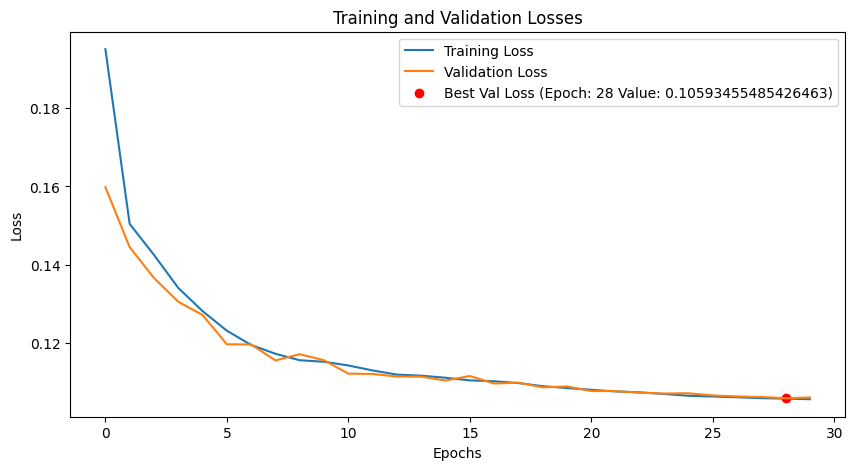

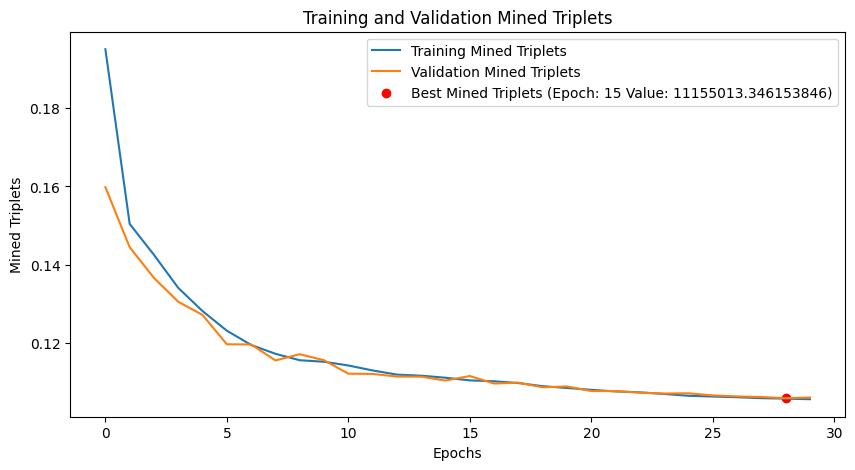

In [18]:
best_val_loss = min(val_losses)
best_val_loss_epoch = val_losses.index(best_val_loss)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.scatter(best_val_loss_epoch, best_val_loss, color='red', label=f'Best Val Loss (Epoch: {best_val_loss_epoch} Value: {best_val_loss})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

best_mined_triplets = min(val_mined_triplets)
best_mined_triplets_epoch = val_mined_triplets.index(best_mined_triplets)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Mined Triplets')
plt.plot(val_losses, label='Validation Mined Triplets')
plt.scatter(best_val_loss_epoch, best_val_loss, color='red', label=f'Best Mined Triplets (Epoch: {best_mined_triplets_epoch} Value: {best_mined_triplets})')
plt.xlabel('Epochs')
plt.ylabel('Mined Triplets')
plt.legend()
plt.title('Training and Validation Mined Triplets')
plt.show()

Embedding Graphs

In [22]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10, 10))
    for i in range(8):
        inds = np.where(targets == i)[0]
        plt.scatter(embeddings[inds, 0], embeddings[inds, 1], alpha=0.5, color=colors[i], label=classes[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(loc='best')
    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    plt.title("t-SNE Embeddings")

def extract_embeddings(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    embeddings = []
    labels = []
    with torch.no_grad():
        for data in dataloader:
            inputs, target_labels = data
            inputs = inputs.to(device)  # Move inputs to the appropriate device
            emb = model.get_embedding(inputs)
            embeddings.append(emb.cpu().numpy())
            labels.append(target_labels.cpu().numpy())
    return np.concatenate(embeddings), np.concatenate(labels)

test_embeddings, test_embedding_labels = extract_embeddings(embedding_model, audio_test_loader)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7adae02a9090>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so: cannot open shared object file: No such file or directory


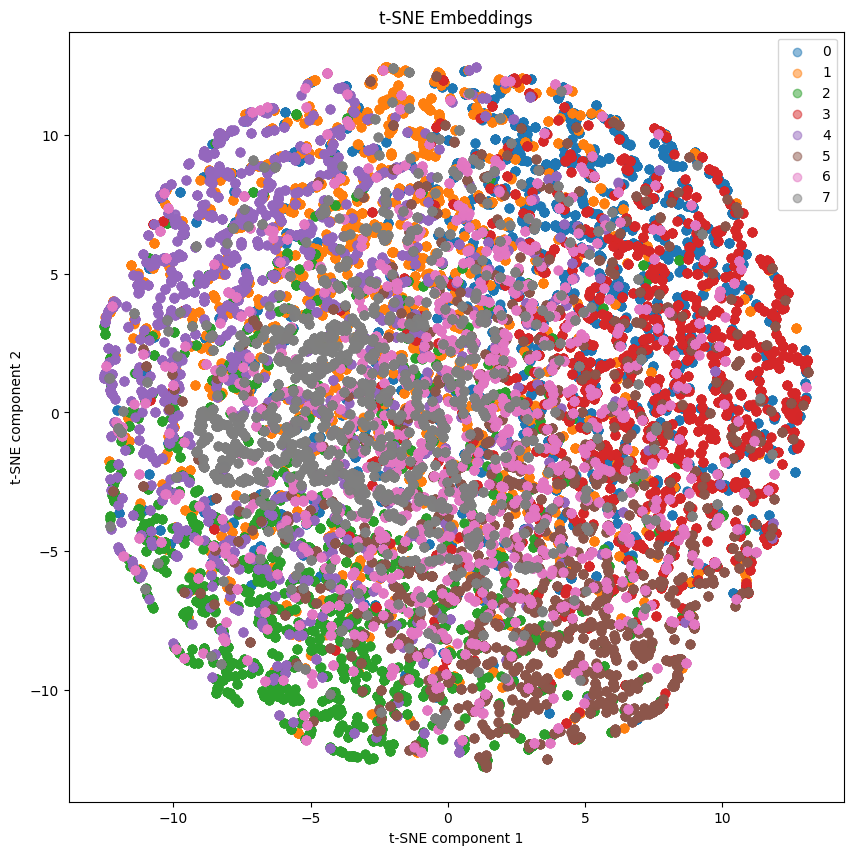

In [23]:
def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, perplexity=50, learning_rate=10, n_iter=1000, random_state=42)
    return tsne.fit_transform(embeddings)

test_embeddings_tsne = apply_tsne(test_embeddings)
plot_embeddings(test_embeddings_tsne, test_embedding_labels)
plt.show()

# Unassign

In [ ]:
runtime.unassign()